In [32]:
import os
from os.path import join
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
from shapely import Point
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import xarray as xr
from haversine import haversine, haversine_vector
import matplotlib.pyplot as plt

In [4]:
no2 = xr.open_dataset("/home/patel_zeel/compass24/data_files/SurfaceNO2_0.0083deg_2020.nc")
no2

<xarray.Dataset> Size: 3GB
Dimensions:     (lat: 16200, lon: 43080)
Coordinates:
  * lat         (lat) float64 130kB -60.05 -60.04 -60.03 ... 74.93 74.94 74.95
  * lon         (lon) float64 345kB -179.5 -179.5 -179.5 ... 179.4 179.4 179.4
Data variables:
    crs         |S1 1B ...
    SurfaceNO2  (lat, lon) float32 3GB ...
Attributes: (12/24)
    GDAL_AREA_OR_POINT:       Area
    Conventions:              CF-1.5
    GDAL:                     GDAL 3.1.2, released 2020/07/07
    title:                    Nitrogen Dioxide Surface-Level Annual Average C...
    NCO:                      netCDF Operators version 4.9.3 (Homepage = http...
    institution:              George Washington University, Department of Env...
    ...                       ...
    SouthBoundingCoordinate:  -60.0
    NorthBoundingCoordinate:  75.0
    WestBoundingCoordinate:   -180.0
    EastBoundingCoordinate:   180.0
    history:                  2023-02-04 12:28:24 - original file generated u...
    VersionID:                1.0

In [28]:
state = "uttar_pradesh"
state_map = {"uttar_pradesh": "Uttar Pradesh", "gujarat": "Gujarat", "haryana": "Haryana", "rajasthan": "Rajasthan", "madhya_pradesh": "Madhya Pradesh"}
kilns = pd.read_csv(f"/home/patel_zeel/compass24/exact_latlon/{state}.csv")
print(kilns.shape)
gdf = gpd.read_file("/home/patel_zeel/India-State-and-Country-Shapefile-Updated-Jan-2020/India_State_Boundary.shp").to_crs(epsg=4326)
print(gdf.columns)
state_gdf = gdf[gdf.State_Name == state_map[state]].unary_union
min_lon, min_lat, max_lon, max_lat = state_gdf.bounds
print(min_lon, min_lat, max_lon, max_lat)

gap = 0.00833 * 10 # 10 km
no2_list = []
kiln_counts = []

def get_pair(i, j):
    no2_val = no2.sel(lat=slice(i, i+gap), lon=slice(j, j+gap))['SurfaceNO2'].mean().item()
    kiln_val = kilns[(kilns.lat >= i) & (kilns.lat <= i+gap) & (kilns.lon >= j) & (kilns.lon <= j+gap)].shape[0]
    return no2_val, kiln_val

pairs = []
for i in np.arange(min_lat, max_lat, gap):
    for j in np.arange(min_lon, max_lon, gap):
        pairs.append((i, j))
        
processed_pairs = Parallel(n_jobs=10)(delayed(get_pair)(i, j) for i, j in tqdm(pairs))

(5823, 18)
Index(['State_Name', 'geometry'], dtype='object')
77.08395481286641 23.870081027704448 84.63475042026772 30.406327104473043


  0%|          | 0/7189 [00:00<?, ?it/s]

In [30]:
print(len(processed_pairs))
non_zero_pairs = [x for x in processed_pairs if x[1] > 0]
print(len(non_zero_pairs))

7189
1634


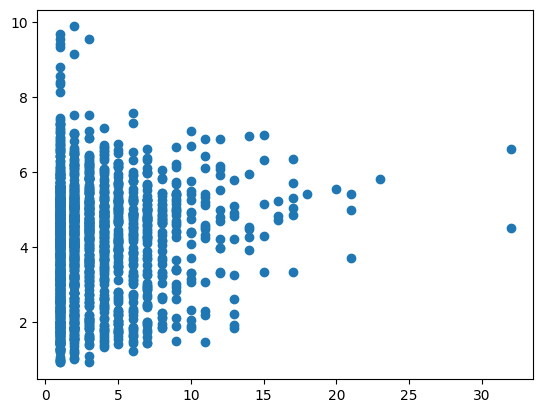

In [34]:
no2_values = [x[0] for x in non_zero_pairs]
kiln_counts = [x[1] for x in non_zero_pairs]

plt.scatter(kiln_counts, no2_values)